Dictionary Learning
===================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$


Instead of using a fixed data representation such as wavelets or Fourier,
one can learn the representation (the dictionary) to optimize the
sparsity of the representation for a large class of exemplar.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from nt_toolbox.signal import load_image, imageplot, plot_dictionary
from nt_toolbox.general import crop

Dictionary Learning as a Non-convex Optimization Problem
--------------------------------------------------------
Given a set $Y = (y_j)_{j=1}^m \in \RR^{n \times m} $ of $m$ signals
$y_j \in \RR^m$, dictionary learning aims at finding the best
dictionary $D=(d_i)_{i=1}^p$ of $p$ atoms $d_i \in \RR^n$ to sparse
code all the data.


In this numerical tour, we consider an application to image denoising, so
that each $y_j \in \RR^n$ is a patch of size $n=w \times w$ extracted
from the noisy image.


The idea of learning dictionaries to sparse code image patch was first
proposed in:


Olshausen BA, and Field DJ.,
<http://www.nature.com/nature/journal/v381/n6583/abs/381607a0.html Emergence of Simple-Cell Receptive Field Properties by Learning a Sparse Code for Natural Images.>
Nature, 381: 607-609, 1996.


The sparse coding of a single data $y=y_j$ for some $j=1,\ldots,m$
is obtained by minimizing a $\ell^0$ constrained optimization
$$ \umin{ \norm{x}_0 \leq k } \frac{1}{2}\norm{y-Dx}^2 .  $$
where the $\ell^0$ pseudo-norm of $x \in \RR^p$ is
$$ \norm{x}_0 = \abs{\enscond{i}{x(i) \neq 0}}. $$


The parameter $k>0$ controls the amount of sparsity.


Dictionary learning performs an optimization both on the dictionary $D$
and the set of coefficients $ X = (x_j)_{j=1}^m \in \RR^{p \times m} $
where, for $j=1,\ldots,m$, $ x_j $
is the set of coefficients of the data $y_j$. This joint optimization reads
$$ \umin{ D \in \Dd, X \in \Xx_k } E(X,D) = \frac{1}{2}\norm{Y-DX}^2 =
\frac{1}{2} \sum_{j=1}^m \norm{y_j - D x_j}^2. $$


The constraint set on $D$ reads
$$ \Dd = \enscond{D \in \RR^{n \times p} }{
      \forall i=1,\ldots,p, \quad \norm{D_{\cdot,i}} \leq 1  }, $$
(the columns of the dictionary are unit normalized).
The sparsity constraint set on $X$ reads
$$ \Xx_k = \enscond{X \in \RR^{p \times m}}{ \forall j, \: \norm{X_{\cdot,j}}_0 \leq k }. $$


We propose to use a block-coordinate descent method to minimize $E$:
$$ X^{(\ell+1)} \in \uargmin{X \in \Xx_k} E(X,D^{(\ell)}), $$
$$ D^{(\ell+1)} \in \uargmin{D \in \Dd} E(X^{(\ell+1)},D). $$


One can show the convergence of this minimization scheme, see for
instance


P. Tseng, <http://www.math.washington.edu/~tseng/papers/archive/bcr_jota.pdf Convergence of Block Coordinate Descent Method for Nondifferentiable Minimization>,
J. Optim. Theory Appl., 109, 2001, 475-494.


We now define the parameter of the problem.


Width $w$ of the patches.

In [2]:
w = 10

Dimension $n= w \times w$ of the data to be sparse coded.

In [3]:
n = w*w

Number of atoms $p$ in the dictionary.

In [4]:
p = 2*n

Number $m$ of patches used for the training.

In [5]:
m = 20*p

Target sparsity $k$.

In [6]:
k = 4

Patch Extraction
----------------
Since the learning is computationnaly intensive, one can only apply it to
small patches extracted from an image.

In [7]:
f = crop(load_image("nt_toolbox/data/barb.bmp"), 256)
n0 = f.shape[0]

Display the input image.

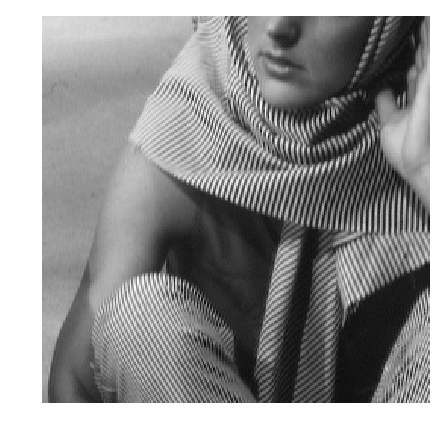

In [8]:
plt.figure(figsize = (5,5))
imageplot(f)

Random patch location.

In [9]:
q = 3*m

# Random sampling of coordinates of the top left corner or the patches
x = (np.random.random((1, 1, q))*(n0-w)).astype(int)
y = (np.random.random((1, 1, q))*(n0-w)).astype(int)

Extract lots of patches $y_j \in \RR^n$, and store them in a matrix $Y=(y_j)_{j=1}^m$.

In [10]:
[dY, dX] = np.meshgrid(range(w), range(w))
dX = np.tile(dX, (q, 1, 1)).transpose((1, 2, 0))
dY = np.tile(dY, (q, 1, 1)).transpose((1, 2, 0))
Xp = np.tile(x, (w, w, 1)) + dX
Yp = dY + np.tile(y, (w, w, 1))

# Extract patches
Y = f.flatten()[Yp+Xp*n0]
Y = Y.reshape((w*w, q))

We remove the mean, since we are going to learn a dictionary of
zero-mean and unit norm atom.

In [11]:
Y -= Y.mean(axis=0)

Only keep those with largest energy.

In [12]:
energies = np.sum(Y**2, axis=0)
indexes = np.argsort(energies)[::-1]
Y = Y[:, indexes[:m]];

We consider a dictionary $D \in \RR^{n \times p} $ of $p \geq n$ atoms in $\RR^n$.
The initial dictionary $D$ is computed by a random selection of patches, and we normalize them to be unit-norm.

In [13]:
def projC(Y):
    ''' Scale the patches to unit norm '''
    norm = np.tile(np.linalg.norm(Y, axis=0), (Y.shape[0], 1))
    Y = np.divide(Y, norm)
    return  Y 

# Pick p indexes at random to pick patches from Y
sel = np.random.permutation(range(m))[:p]
D = projC(Y[:, sel])
D0 = D.copy()

Display the initial dictionary.

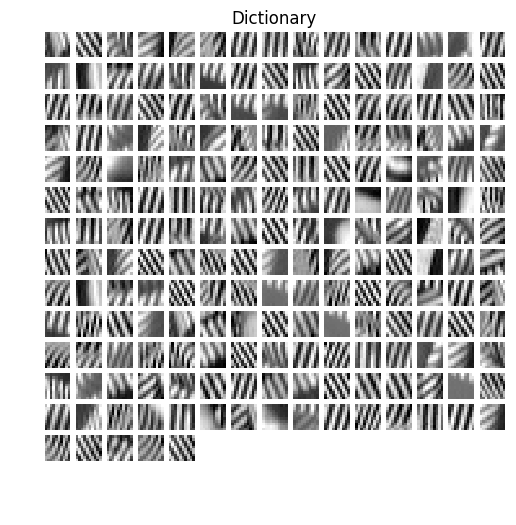

In [14]:
plt.figure(figsize=(10,6))
plot_dictionary(D)

Update of the Coefficients $X$
--------------------------------
The optimization on the coefficients $X$ requires, for each $y_j =
Y_{\cdot,j}$ to compute $x_j = X_{\cdot,j}$ that solves
$$ \umin{ \norm{x_j}_0 \leq k } \frac{1}{2} \norm{y-D x_j}^2. $$


This is a non-smooth and non-convex minimization, that can be shown to be
NP-hard. A heuristic to solve this method is to compute a stationary
point of the energy using the Foward-Backward iterative scheme (projected gradient descent):
$$ x_j \leftarrow \text{Proj}_{\Xx_k}\pa{
      x_j - \tau D^* ( D x_j - y )
      }$
      \qwhereq \tau < \frac{2}{\norm{D D^*}}. $$


Denoting $\abs{\bar x(1)} \leq \ldots \leq \abs{\bar x(n)}$ the ordered
magnitudes of a vector $ x \in \RR^n $, the orthogonal projector on
$\Xx_k$ reads $z = \text{Proj}_{\Xx_k}(x)$ with
$$ \forall i=1,\ldots,n, \quad
      z(i) = \choice{ x(i) \qifq \abs{x(i)} \geq \abs{\bar x(k)}, \\
      z(i) = 0 \quad \text{otherwise}.
  }$
$$

In [15]:
def projX(X, k):
    ''' Sparsity projection, keeps the k largest coefficients '''
    X = X * (abs(X) >= np.sort(abs(X), axis=0)[-k, :])
    return X

__Exercise 1__

Perform the iterative hard thresholding,
and display the decay of the energy $J(x_j) = \norm{y_j-D x_j}^2$ for several $j$.
_Remark:_ note that the iteration can be performed in parallel on all
$x_j$.

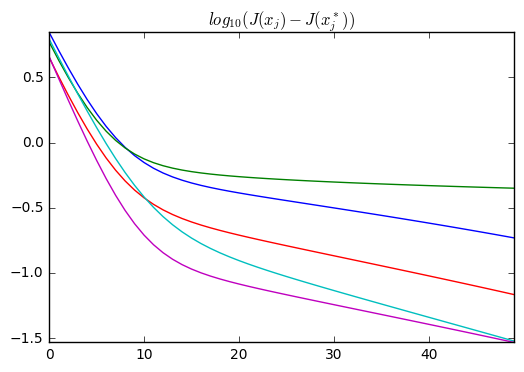

In [16]:
run -i nt_solutions/sparsity_4_dictionary_learning/exo1

In [17]:
## Insert your code here.

Update the Dictionary $D$
---------------------------
Once the sparse coefficients $X$ have been computed, one
can udpate the dictionary. This is achieve by performing the minimization
$$ \umin{D \in \Dd} \frac{1}{2}\norm{Y-D X}^2. $$


One can perform this minimization with a projected gradient descent
$$ D \leftarrow \text{Proj}_{\Cc}\pa{ D - \tau (DX - Y)X^* } $$
where $ \tau < 2/\norm{XX^*}. $


Note that the orthogonal projector $\text{Proj}_{\Cc}$ is implemented in the function
|ProjC| already defined.

__Exercise 2__

Perform this gradient descent, and monitor the decay of the energy.

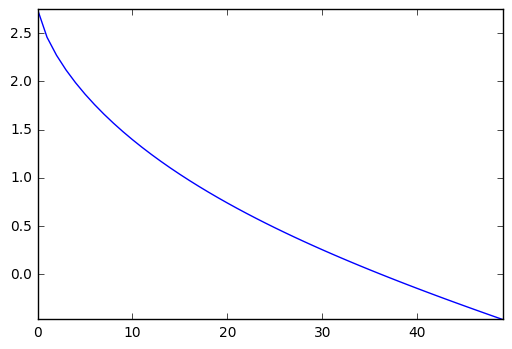

In [18]:
run -i nt_solutions/sparsity_4_dictionary_learning/exo2

In [19]:
## Insert your code here.

__Exercise 3__

Perform the dictionary learning by iterating between sparse coding and
dictionary update.

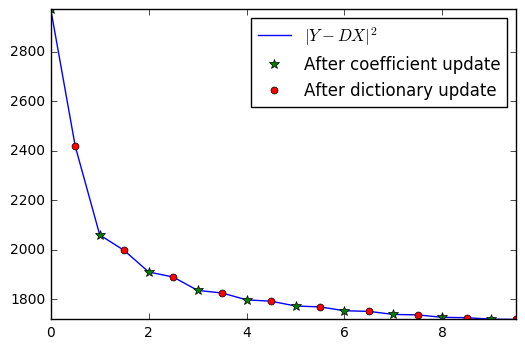

In [20]:
run -i nt_solutions/sparsity_4_dictionary_learning/exo3

In [21]:
## Insert your code here.

Display the dictionary.

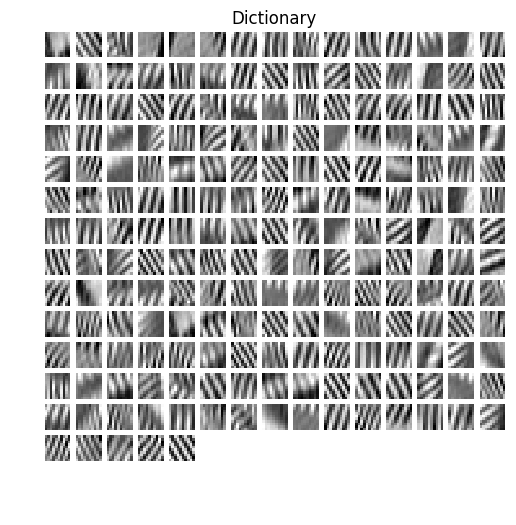

In [22]:
plt.figure(figsize=(10,6))
plot_dictionary(D)